<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/2020_11_24_GridSearchCV_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# !!VIRTUALLY DONE!! 
Ideally - no more changes here, there's a lot of meat to this one and I need to use it to generate results for report, can't afford to break it :) 

# WORDS OF CAUTION

I initially ran GridSearchCV on the whole X,y dataset (i.e. ignoring X_train/ y_train, X_test/ y_test) and spat out the best results without evaluation on unseen data. See...
* See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

i.e. With GridSearchCV, I need to..
* setup model
* fit with X_train/ y_train
* evaluate and find best model
* take best model and use X_test/ y_test on it





Also from...
* https://stackoverflow.com/a/55605798

"Internally, GridSearchCV splits the dataset given to it into various training and validation subsets, and, using the hyperparameter grid provided to it, finds the single set of hyperparameters that give the best score on the validation subsets.

The point of a train-test split is then, after this process is done, to perform one final scoring on the test data, which has so far been unknown to the model, to see if your hyperparameters have been overfit to the validation subsets. If it does well, then the next step is putting the model into production/deployment."

# Setup Colab env


In [1]:

import sklearn
sklearn.__version__
#!pip uninstall scikit-learn -y
#!pip install scikit-learn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [25]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Google drive access

In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# peek at modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27  2020 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27  2020 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27  2020 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27  2020 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27  2020 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27  2020 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27  2020 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27  2020 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27  2020 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27  2020 9_soul-groove9_105_beat_4-4.mid
total 57
-rw------- 1 root root 33561 Dec 13 15:21 data_prep.py
-rw------- 1 root root  2904 Nov 18 21:57 pipeline_utils.py
drwx------ 2 root root  4096 May 10  2020 __pycache__
-rw------- 1 root root  7847 Aug 18 22:09 stats_n_features.py
-rw------- 1 root root 

## Auto reload module

Now using library code I've created and saved to google drive which is automatically pushed to the cloud and made available to the colab env. The autoreload stuff below should help imports to 'reimport' to load changes to the library code.

It's not the quickest/ most reliable, so if in a hurry, brute force loading of changes by restarting the runtime.

In [5]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

## Imports and accessing lib functions

In [4]:
# regular imports
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

# object that provides colours for charts
from itertools import cycle

# sklearn imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from scipy import stats

In [8]:
# install required libs
!pip install mido

In [7]:
# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep as dp
import pipeline_utils as pu
import stats_n_features as sf

>> LOADING custom module, when: 2020-12-13 16:14:54.066396, module name: stats_n_features
>> LOADING custom module, when: 2020-12-13 16:14:54.067382, module name: data_prep
>> LOADING custom module, when: 2020-12-13 16:14:54.071611, module name: pipeline_utils


In [8]:
# test module function calls..
dp.test_function_call('bling')
sf.test_function_call('hello')

Test function in data_prep.py called and worked! when: 2020-12-13 16:14:56.737197,  param:bling
Test function in stats_n_features called and worked! when: 2020-12-13 16:14:56.737348,  param:hello


## Pandas display options

In [24]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 2000
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Load & filter data...

In [ ]:
##################################
######## LOAD

my_data = dp.load_all_data()
all_drummer_data = my_data.copy()
;

In [11]:
logs_df = dp.get_last_logs()
display(logs_df.head(3))
filtered_logs_df = logs_df[['style', 'tempo_us', 'tempo_bpm', 'ts_num', 'ts_den', 'PPQN', 'bars_in_file', 'ticks_per_bin', 'ms_per_bin']]
#check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode, 'nunique'])
check_stats_df = filtered_logs_df.groupby('style').agg([pd.Series.mode])
check_stats_df.columns = check_stats_df.columns.droplevel(1)
#check_stats_df.to_csv(r'/content/drive/My Drive/check_stats_df.csv')
display(check_stats_df)

,file_name,style,drummer,file_type,ts_num,ts_den,tempo_us,tempo_bpm,PPQN,first_hit,last_hit,bars_in_file,quantize_level,ticks_per_beat,ticks_per_bin,ms_per_bin,err_buckets
0,drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid,funk/groove1,drummer1,0,4,4,434783,137.999876,480,3,30658,16,16.0,480.0,120,0.108696,"(24, 13)"
1,drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid,soul/groove3,drummer1,0,4,4,697674,86.000052,480,0,30696,16,16.0,480.0,120,0.174419,"(8, 13)"
2,drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid,soul/groove4,drummer1,0,4,4,750000,80.000000,480,0,30470,16,16.0,480.0,120,0.187500,"(0, 13)"


,tempo_us,tempo_bpm,ts_num,ts_den,PPQN,bars_in_file,ticks_per_bin,ms_per_bin
style,,,,,,,,
funk/groove1,434783,137.999876,4,4,480,16,120,0.108696
hiphop/groove6,689655,87.000022,4,4,480,16,120,0.172414
rock/groove8,923077,64.999995,4,4,480,16,120,0.230769
soul/groove3,697674,86.000052,4,4,480,16,120,0.174419
soul/groove4,750000,80.000000,4,4,480,16,120,0.187500


In [12]:
# new method of loading data..
master_df = all_drummer_data['master_df']

## Filter songs...

Take a look at all file names in the complete data set...

In [13]:
list(all_drummer_data.keys())

['/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/6_hiphop-groove6_87_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/8_rock-groove8_65_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/1_funk-groove1_138_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/3_soul-groove3_86_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/4_soul-groove4_80_beat_4-4.mid',
 '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer5/eval_session/6_hiphop-groove6_87_beat_4-4.m

In [14]:
# compare to new method of loading data..
master_df.head(3)

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1


# Setup & select data to use

**NOTE: v1 data format reqd for modelling**

Specifically, these models initially setup to use DFs with the following features...
1. drummer_ID
2. note
3. velocity
4. beat_offset	
5. bar_beat_number

In v2 of the dataframes from the loading code includes additional cols for ..
6. beat_offset_ms
7. style

When doing further work on models using v2 versions of data, need to ensure to drop cols for  'beat_offset_ms' and 'style' to duplicate previous results.

**v2 example...**

In [118]:
master_df.head()
print('\n > list of styles in dataset: {}'.format(master_df['style'].unique()))

,drummer_ID,note,velocity,beat_offset,beat_offset_ms,bar_beat_number,style
0,drummer1,hh,55,7,0.006341,1,funk/groove1
1,drummer1,kick,64,10,0.009058,1,funk/groove1
2,drummer1,kick,57,-29,-0.026268,3,funk/groove1
3,drummer1,hh,31,-2,-0.001812,3,funk/groove1
4,drummer1,hh,54,-13,-0.011775,5,funk/groove1



 > list of styles in dataset: ['funk/groove1' 'soul/groove3' 'soul/groove4' 'hiphop/groove6'
 'rock/groove8']


**v1 example, drop cols steps reqd...**

In [100]:
# drop cols to exclude from modelling
master_df.drop(columns=['beat_offset_ms', 'style']).head()

,drummer_ID,note,velocity,beat_offset,bar_beat_number
0,drummer1,hh,55,7,1
1,drummer1,kick,64,10,1
2,drummer1,kick,57,-29,3
3,drummer1,hh,31,-2,3
4,drummer1,hh,54,-13,5


## Song style selection

In [260]:
# make a copy
working_data = master_df.copy() 

# select/ filter to subset of styles if required.
# skip this step, comment out next line of code to use all data
# select from ['funk/groove1' 'soul/groove3' 'soul/groove4' 'hiphop/groove6' 'rock/groove8']
#working_data = working_data[working_data['style'] == 'soul/groove3']

# drop cols to exclude from modelling
#working_data.drop(columns=['beat_offset_ms', 'style'], inplace=True)
working_data.drop(columns=['beat_offset_ms'], inplace=True)

In [261]:
working_data.head(3)
working_data.describe(include='all')

,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
0,drummer1,hh,55,7,1,funk/groove1
1,drummer1,kick,64,10,1,funk/groove1
2,drummer1,kick,57,-29,3,funk/groove1


,drummer_ID,note,velocity,beat_offset,bar_beat_number,style
count,5631,5631,5631.000000,5631.000000,5631.000000,5631
unique,4,3,NaN,NaN,NaN,5
top,drummer1,hh,NaN,NaN,NaN,soul/groove3
freq,1498,3235,NaN,NaN,NaN,1677
mean,NaN,NaN,68.054520,-5.153969,8.320902,NaN
std,NaN,NaN,33.876204,14.429171,4.574257,NaN
min,NaN,NaN,4.000000,-60.000000,1.000000,NaN
25%,NaN,NaN,40.500000,-14.000000,5.000000,NaN
50%,NaN,NaN,62.000000,-5.000000,8.000000,NaN
75%,NaN,NaN,96.000000,3.000000,12.000000,NaN


## X, y split

Break into X, y before continuing ...

In [262]:
# BREAK INTO X, y
y = working_data['drummer_ID'].to_numpy()
X = working_data.drop(['drummer_ID' ], axis=1) #.to_numpy()

In [263]:
X.head(10)

,note,velocity,beat_offset,bar_beat_number,style
0,hh,55,7,1,funk/groove1
1,kick,64,10,1,funk/groove1
2,kick,57,-29,3,funk/groove1
3,hh,31,-2,3,funk/groove1
4,hh,54,-13,5,funk/groove1
5,snare,93,-5,5,funk/groove1
6,hh,42,-16,7,funk/groove1
7,snare,33,-12,8,funk/groove1
8,snare,33,-14,10,funk/groove1
9,kick,59,-37,11,funk/groove1


## Train/ test split...

TODO: compare use of stratify parameter, with not using it?

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [276]:
# TEST/ TRAIN SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27, stratify=y)


In [277]:
X_train.head(3)

,note,velocity,beat_offset,bar_beat_number,style
2777,hh,43,-6,7,rock/groove8
4085,snare,38,-1,15,rock/groove8
2011,kick,34,-34,4,soul/groove3


In [278]:
X_train.describe(include='all')
X_test.describe(include='all')

,note,velocity,beat_offset,bar_beat_number,style
count,4504,4504.000000,4504.000000,4504.000000,4504
unique,3,NaN,NaN,NaN,5
top,hh,NaN,NaN,NaN,soul/groove3
freq,2592,NaN,NaN,NaN,1358
mean,NaN,67.912522,-5.238899,8.294849,NaN
std,NaN,33.930346,14.323884,4.571063,NaN
min,NaN,4.000000,-60.000000,1.000000,NaN
25%,NaN,40.000000,-14.000000,5.000000,NaN
50%,NaN,61.000000,-5.000000,8.000000,NaN
75%,NaN,96.000000,3.000000,12.000000,NaN


,note,velocity,beat_offset,bar_beat_number,style
count,1127,1127.000000,1127.000000,1127.000000,1127
unique,3,NaN,NaN,NaN,5
top,hh,NaN,NaN,NaN,soul/groove3
freq,643,NaN,NaN,NaN,319
mean,NaN,68.622005,-4.814552,8.425022,NaN
std,NaN,33.667966,14.844135,4.587555,NaN
min,NaN,5.000000,-60.000000,1.000000,NaN
25%,NaN,41.000000,-14.000000,5.000000,NaN
50%,NaN,64.000000,-5.000000,9.000000,NaN
75%,NaN,96.000000,4.000000,12.000000,NaN


# Setup pipelines

In [279]:
working_data.corr()

,velocity,beat_offset,bar_beat_number
velocity,1.000000,0.138234,-0.016559
beat_offset,0.138234,1.000000,0.002980
bar_beat_number,-0.016559,0.002980,1.000000


## Create transformers

In [280]:
beat_pos_cats = list(np.arange(1, 17))
beat_pos_cats

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [281]:
t_one_hot_beat_pos = OneHotEncoder(drop='first', categories=[beat_pos_cats])    # beat_pos

t_scaler_std = StandardScaler(with_mean=True, with_std=True) # defaults made explict, velocity, beat_offset

t_one_hot = OneHotEncoder(drop='first')    # instrument, style
t_scaler_robust = RobustScaler(quantile_range=(25, 75))  # try with: velocity, beat_offset
t_scaler_mm_1 = MinMaxScaler(feature_range=(0, 1))       # velocity
t_scaler_mm_2 = MinMaxScaler(feature_range=(-0.5, 0.5))  # beat_offset

# robust scaling of vel & offset, one hot for instrument  
t_v0_robust = [('t_scaler_robust', t_scaler_robust, ['velocity', 'beat_offset']), 
               ('t_one_hot', t_one_hot, ['note', 'style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v0 = ColumnTransformer(transformers=t_v0_robust, remainder='passthrough', sparse_threshold=0)
 
# MinMax scaling of vel & offset, one hot for instrument & beat_pos
t_v1_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']),
               ('t_one_hot', t_one_hot, ['note', 'style']),
               ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])] 
ct_v1 = ColumnTransformer(transformers=t_v1_mm, remainder='passthrough', sparse_threshold=0)

# MinMax scaling of vel & offset, one hot for instrument
t_v2_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity']),
               ('t_scaler_mm_2', t_scaler_mm_2, ['beat_offset']), 
               ('t_one_hot', t_one_hot, ['note', 'style'])]
ct_v2 = ColumnTransformer(transformers=t_v2_mm, remainder='passthrough', sparse_threshold=0)


# MinMax scaling of vel & offset, one hot for note
t_v3_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity', 'beat_offset']), ('t_one_hot', t_one_hot, ['note', 'style'])]
ct_v3 = ColumnTransformer(transformers=t_v3_mm, remainder='passthrough', sparse_threshold=0)

# Std scaling of vel & offset, one hot for note and beat_pos.
# NOTE: this is the least 'custom'
t_v4_std = [('t_scaler_std', t_scaler_std, ['velocity', 'beat_offset']),
           ('t_one_hot', t_one_hot, ['note', 'style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v4 = ColumnTransformer(transformers=t_v4_std, remainder='passthrough', sparse_threshold=0)

# this is like ct_v3, but added in handling for  'bar_beat_number'
t_v5_mm = [('t_scaler_mm_1', t_scaler_mm_1, ['velocity', 'beat_offset']), 
           ('t_one_hot', t_one_hot, ['note', 'style']),
           ('t_one_hot_beat_pos', t_one_hot_beat_pos, ['bar_beat_number'])]
ct_v5 = ColumnTransformer(transformers=t_v5_mm, remainder='passthrough', sparse_threshold=0)


# NOTE: I'd have thought ct_v4 (standard) and ct_v0 (robust) would have come out
#   best, but they don't appear to be in the running ...


In [282]:
# new one to just encode 'note', leave everything else untouched
# i.e. no scaling or dummies needed, e.g. for DT
from sklearn.preprocessing import OrdinalEncoder
t_note_enc = [('t_label_enc', OrdinalEncoder(), ['note','style'])]
ct_note_enc = ColumnTransformer(transformers=t_note_enc, remainder='passthrough', sparse_threshold=0)


In [283]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context


In [284]:
ct_v0
ct_v1
ct_v2
ct_v3
ct_v4
ct_v5

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_robust',
                                 RobustScaler(quantile_range=(25, 75)),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(), ['velocity']),
                                ('t_scaler_mm_2',
                                 MinMaxScaler(feature_range=(-0.5, 0.5)),
                                 ['beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_std', StandardScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style']),
                                ('t_one_hot_beat_pos',
                                 OneHotEncoder(categories=[[1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13, 14, 15, 16]],
                                               drop='first'),
                                 ['bar_beat_number'])])

## Sanity checking ..


Try a transformer, peek at the outputs...

In [285]:
output1 = ct_v1.fit_transform(X)
output2 = ct_v2.fit_transform(X)
output3 = ct_v3.fit_transform(X)
output4 = ct_v4.fit_transform(X)
output5 = ct_v5.fit_transform(X)

In [241]:
output1.shape
pd.DataFrame(output1).head()

(5631, 24)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.414634,0.063025,0.044195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.487805,0.088235,0.058623,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.430894,-0.239496,-0.128941,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.219512,-0.012605,0.000911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.406504,-0.105042,-0.051992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [299]:
output2.shape
tmp_df = pd.DataFrame(output2)
tmp_df.head()
#tmp_df.corr()


(5631, 9)

,0,1,2,3,4,5,6,7,8
0,0.414634,0.063025,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.487805,0.088235,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.430894,-0.239496,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.219512,-0.012605,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.406504,-0.105042,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [300]:
output3.shape
tmp_df = pd.DataFrame(output3)
tmp_df.head()
#tmp_df.corr()

(5631, 9)

,0,1,2,3,4,5,6,7,8
0,0.414634,0.563025,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.487805,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.430894,0.260504,1.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.219512,0.487395,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.406504,0.394958,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [301]:
output4.shape
tmp_df = pd.DataFrame(output4)
tmp_df.head()
#tmp_df.corr()

(5631, 23)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.385394,0.842394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.119697,1.050325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.326350,-1.652773,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.093919,0.218602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.414916,-0.543810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Some pipelines

In [286]:
# setup our pre-processing and modelling pipeline
pipe_v0 = Pipeline(steps=[('prep',ct_v0), ('knn', KNeighborsClassifier(7))])
pipe_v1 = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
pipe_v2 = Pipeline(steps=[('prep',ct_v2), ('knn', KNeighborsClassifier(7))])
pipe_v3 = Pipeline(steps=[('prep',ct_v3), ('knn', KNeighborsClassifier(7))])
pipe_v4 = Pipeline(steps=[('prep',ct_v4), ('knn', KNeighborsClassifier(7))])
pipe_v5 = Pipeline(steps=[('prep',ct_v5), ('knn', KNeighborsClassifier(7))])


# Manual KNN to test pipelines

## Util functions


In [287]:

def KNN_predict(X_train, y_train, X_test, n=5):
  # Fit model, do predictions

  KNN_model = KNeighborsClassifier(n)
  display(KNN_model)
  KNN_model.fit(X_train, y_train)
  return KNN_model.predict(X_test)

def KNN_results(pred, test, labels):
  # evaluate results

  print('\nKNN Accuracy score...')
  print('  KNN: {}'.format(accuracy_score(pred, test)))

  print('\nKNN classification report...')
  print(classification_report(pred, test))

def c_matrix(pred, test, labels):
  # plot results

  print('\nConfusion matrix...')
  matrix2 = confusion_matrix(pred, test)
  m_df = pd.DataFrame(matrix2, index=labels, columns=labels)
  _ = plt.figure(figsize=(6, 6))
  sns.heatmap(m_df, annot=True, cbar=None, cmap="Reds")
  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.show()



## Manual fit model, do predictions

Testing single model by hand

In [288]:
print('fitting the pipeline ...')
#pipe_v3.fit(X_train, y_train)
#pipe_v0.fit(X_train, y_train)
pipe_v5.fit(X_train, y_train)

print('predicting ...')
#predictions_1 = pipe_v3.predict(X_test)
#predictions_1 = pipe_v0.predict(X_test)
predictions_1 = pipe_v5.predict(X_test)

fitting the pipeline ...


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn', KNeighborsClassifier(n_neighbors=7))])

predicting ...


## Evaluate model results


KNN Accuracy score...
  KNN: 0.650399290150843

KNN classification report...
              precision    recall  f1-score   support

    drummer1       0.64      0.60      0.62       320
    drummer5       0.71      0.64      0.67       297
    drummer7       0.57      0.67      0.61       233
    drummer8       0.69      0.71      0.70       277

    accuracy                           0.65      1127
   macro avg       0.65      0.65      0.65      1127
weighted avg       0.65      0.65      0.65      1127


Confusion matrix...


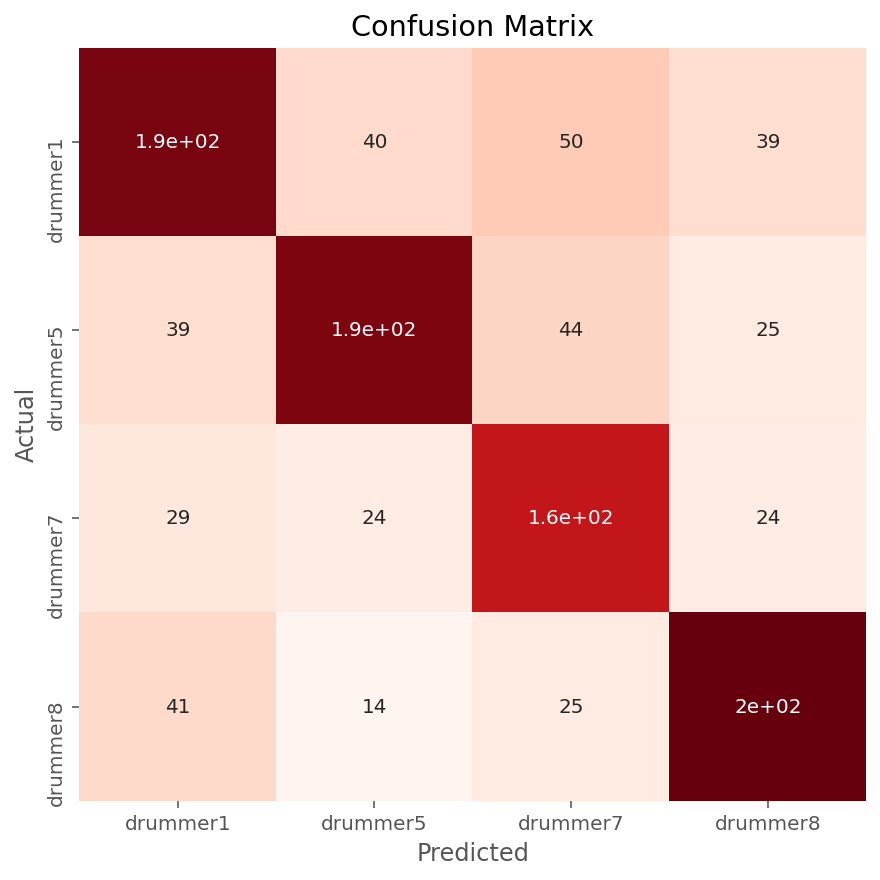

In [290]:
# y = list of all y values from dataset
classes = np.unique(y)
KNN_results(predictions_1, y_test, classes)
c_matrix(predictions_1, y_test, classes)

# DummyClassifier
See...
* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier

In [291]:
from sklearn.dummy import DummyClassifier

# uniform, stratified, most_frequent, prior, constant
clf = DummyClassifier(strategy='stratified', random_state=0)
clf.fit(X_train, y_train)

print('clf score: {}'.format(clf.score(X_test, y_test)))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

DummyClassifier(random_state=0, strategy='stratified')

clf score: 0.23247559893522626
              precision    recall  f1-score   support

    drummer1       0.22      0.23      0.23       300
    drummer5       0.24      0.24      0.24       267
    drummer7       0.23      0.19      0.21       275
    drummer8       0.25      0.26      0.25       285

    accuracy                           0.23      1127
   macro avg       0.23      0.23      0.23      1127
weighted avg       0.23      0.23      0.23      1127



# K-fold CV, manual loop thru pipes

Compares..
* k=1-20
* 4 different pre-processing pipes

::TODO:: try different cv values.

In [292]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()

# list of ColumnTransformers setup earlier ..
cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_v5]


results = []
best_score = 0
best_info = ''
best_pipe = None
best_k = 0

#kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=27)
#kf = KFold(n_splits=10, shuffle=True, random_state=27)
kf = KFold(n_splits=10, shuffle=True, random_state=999)


for idx, ct in enumerate(cts):
  print("\n_______________________________________________________")
  print("\n>>>> pipe #{}.. \n".format(idx))
  
  # Calculating error for K values between 1 and 20
  for next_k in range(1, 20):
    next_pipe = Pipeline(steps=[('prep',ct), ('pca', pca), ('knn', KNeighborsClassifier(next_k))])
    cv_results = cross_val_score(next_pipe, X_train, y_train, cv=kf, scoring="accuracy", n_jobs=-1 )
    results.append(cv_results)

    # print out put of this run.
    this_mean = cv_results.mean()
    this_run = "pipe #{}, k={}, mean:{}".format(idx, next_k, this_mean)
    print('\n\n ___ '+this_run)
    cv_results

    # check for best
    if this_mean > best_score:
      best_score = this_mean
      best_info = this_run
      best_pipe = next_pipe
      best_k = next_k
    
print("\n\nBest score was > {}".format(best_score))
print(best_info)




_______________________________________________________

>>>> pipe #0.. 



 ___ pipe #0, k=1, mean:0.6101152993348116


array([0.6097561 , 0.61862528, 0.63858093, 0.61419069, 0.59777778,
       0.62      , 0.61555556, 0.59111111, 0.61333333, 0.58222222])



 ___ pipe #0, k=2, mean:0.5799221483123922


array([0.57871397, 0.59423503, 0.58314856, 0.59423503, 0.56444444,
       0.58666667, 0.58      , 0.56      , 0.57555556, 0.58222222])



 ___ pipe #0, k=3, mean:0.600339985218034


array([0.6075388 , 0.61640798, 0.6097561 , 0.63636364, 0.60444444,
       0.60666667, 0.59333333, 0.55777778, 0.57555556, 0.59555556])



 ___ pipe #0, k=4, mean:0.5901364868194137


array([0.61862528, 0.59645233, 0.57871397, 0.59201774, 0.58444444,
       0.59777778, 0.59111111, 0.56666667, 0.57555556, 0.6       ])



 ___ pipe #0, k=5, mean:0.5841340231584133


array([0.62527716, 0.60532151, 0.55432373, 0.61197339, 0.56666667,
       0.56666667, 0.56444444, 0.57111111, 0.57333333, 0.60222222])



 ___ pipe #0, k=6, mean:0.5665902931756591


array([0.6097561 , 0.59423503, 0.54767184, 0.59201774, 0.54888889,
       0.54      , 0.54666667, 0.54444444, 0.57111111, 0.57111111])



 ___ pipe #0, k=7, mean:0.5759162355259916


array([0.6075388 , 0.60088692, 0.56984479, 0.59866962, 0.57333333,
       0.55111111, 0.55555556, 0.55555556, 0.55777778, 0.58888889])



 ___ pipe #0, k=8, mean:0.5621532397142153


array([0.59423503, 0.57427938, 0.53880266, 0.60310421, 0.55777778,
       0.54      , 0.54666667, 0.54888889, 0.54      , 0.57777778])



 ___ pipe #0, k=9, mean:0.554831239221483


array([0.57206208, 0.58093126, 0.53658537, 0.56984479, 0.53333333,
       0.54444444, 0.54      , 0.54444444, 0.53555556, 0.59111111])



 ___ pipe #0, k=10, mean:0.5432929292929293


array([0.56762749, 0.55210643, 0.49667406, 0.5654102 , 0.52      ,
       0.56222222, 0.52666667, 0.53111111, 0.52      , 0.59111111])



 ___ pipe #0, k=11, mean:0.5375131805863513


array([0.5654102 , 0.5631929 , 0.51441242, 0.54767184, 0.52666667,
       0.55333333, 0.50444444, 0.51333333, 0.51333333, 0.57333333])



 ___ pipe #0, k=12, mean:0.530410445922641


array([0.53658537, 0.55875831, 0.51662971, 0.54101996, 0.52      ,
       0.54444444, 0.49777778, 0.50666667, 0.50888889, 0.57333333])



 ___ pipe #0, k=13, mean:0.5232988420793298


array([0.53658537, 0.55654102, 0.50997783, 0.55210643, 0.51333333,
       0.52      , 0.48444444, 0.49555556, 0.50888889, 0.55555556])



 ___ pipe #0, k=14, mean:0.5208588322246859


array([0.5232816 , 0.54323725, 0.51884701, 0.54988914, 0.50222222,
       0.53333333, 0.5       , 0.49333333, 0.50444444, 0.54      ])



 ___ pipe #0, k=15, mean:0.517090909090909


array([0.53436807, 0.51441242, 0.51441242, 0.52771619, 0.49333333,
       0.50666667, 0.50444444, 0.52444444, 0.50888889, 0.54222222])



 ___ pipe #0, k=16, mean:0.5137585612219758


array([0.52549889, 0.50110865, 0.52993348, 0.52993348, 0.50666667,
       0.5       , 0.5       , 0.50888889, 0.49777778, 0.53777778])



 ___ pipe #0, k=17, mean:0.5093195368317319


array([0.52771619, 0.50997783, 0.51219512, 0.51219512, 0.49111111,
       0.51777778, 0.50666667, 0.50666667, 0.48888889, 0.52      ])



 ___ pipe #0, k=18, mean:0.4988883961566889


array([0.50997783, 0.50554324, 0.50332594, 0.48337029, 0.49333333,
       0.48666667, 0.49777778, 0.51333333, 0.48444444, 0.51111111])



 ___ pipe #0, k=19, mean:0.49023059866962304


array([0.50332594, 0.50776053, 0.4789357 , 0.47228381, 0.48444444,
       0.48222222, 0.49111111, 0.49111111, 0.47555556, 0.51555556])


_______________________________________________________

>>>> pipe #1.. 



 ___ pipe #1, k=1, mean:0.6314220251293422


array([0.64079823, 0.64523282, 0.65853659, 0.65631929, 0.61555556,
       0.63333333, 0.62      , 0.60444444, 0.64444444, 0.59555556])



 ___ pipe #1, k=2, mean:0.619650160137965


array([0.64966741, 0.63858093, 0.64079823, 0.64523282, 0.59333333,
       0.63111111, 0.59333333, 0.58222222, 0.62      , 0.60222222])



 ___ pipe #1, k=3, mean:0.6451879773343188


array([0.66962306, 0.64745011, 0.654102  , 0.68292683, 0.63333333,
       0.62666667, 0.61777778, 0.63777778, 0.65111111, 0.63111111])



 ___ pipe #1, k=4, mean:0.6369770879526978


array([0.67627494, 0.66297118, 0.61862528, 0.64523282, 0.62444444,
       0.62666667, 0.62      , 0.62222222, 0.65555556, 0.61777778])



 ___ pipe #1, k=5, mean:0.6447445183542744


array([0.66962306, 0.66962306, 0.66075388, 0.64966741, 0.62444444,
       0.66666667, 0.61555556, 0.62      , 0.65111111, 0.62      ])



 ___ pipe #1, k=6, mean:0.6345291943828528


array([0.67627494, 0.66297118, 0.63636364, 0.64301552, 0.63555556,
       0.64666667, 0.60888889, 0.62444444, 0.62666667, 0.58444444])



 ___ pipe #1, k=7, mean:0.6340906627248091


array([0.66518847, 0.6518847 , 0.63414634, 0.64079823, 0.63777778,
       0.65333333, 0.60888889, 0.61111111, 0.63111111, 0.60666667])



 ___ pipe #1, k=8, mean:0.6187686622320768


array([0.64523282, 0.64745011, 0.61197339, 0.63636364, 0.62222222,
       0.62      , 0.6       , 0.6       , 0.62      , 0.58444444])



 ___ pipe #1, k=9, mean:0.6130002463661001


array([0.6518847 , 0.61419069, 0.62305987, 0.6097561 , 0.61555556,
       0.61777778, 0.58888889, 0.58888889, 0.62888889, 0.59111111])



 ___ pipe #1, k=10, mean:0.6030022172949002


array([0.66075388, 0.61862528, 0.61419069, 0.59645233, 0.59333333,
       0.60666667, 0.57777778, 0.58666667, 0.60666667, 0.56888889])



 ___ pipe #1, k=11, mean:0.5919078590785907


array([0.62749446, 0.60532151, 0.59423503, 0.58758315, 0.58222222,
       0.61333333, 0.56444444, 0.58      , 0.59777778, 0.56666667])



 ___ pipe #1, k=12, mean:0.58169992609017


array([0.62749446, 0.58758315, 0.56097561, 0.57427938, 0.57777778,
       0.58666667, 0.58      , 0.56222222, 0.58444444, 0.57555556])



 ___ pipe #1, k=13, mean:0.5754762256713477


array([0.6075388 , 0.6097561 , 0.5654102 , 0.57427938, 0.56      ,
       0.57777778, 0.56888889, 0.56666667, 0.57333333, 0.55111111])



 ___ pipe #1, k=14, mean:0.5652633653609264


array([0.60532151, 0.58093126, 0.56762749, 0.56097561, 0.56222222,
       0.57111111, 0.54222222, 0.54888889, 0.56444444, 0.54888889])



 ___ pipe #1, k=15, mean:0.5566026114806603


array([0.58314856, 0.59645233, 0.55432373, 0.55432373, 0.53777778,
       0.54222222, 0.53333333, 0.54888889, 0.55333333, 0.56222222])



 ___ pipe #1, k=16, mean:0.5432855383099284


array([0.58093126, 0.58093126, 0.52771619, 0.52549889, 0.52222222,
       0.53555556, 0.54666667, 0.51777778, 0.56222222, 0.53333333])



 ___ pipe #1, k=17, mean:0.5315186006405519


array([0.53880266, 0.58536585, 0.51662971, 0.52549889, 0.52      ,
       0.54      , 0.51777778, 0.51111111, 0.54222222, 0.51777778])



 ___ pipe #1, k=18, mean:0.5175333826065533


array([0.53215078, 0.57427938, 0.48780488, 0.50554324, 0.50444444,
       0.52222222, 0.52      , 0.48444444, 0.54      , 0.50444444])



 ___ pipe #1, k=19, mean:0.5059866962305987


array([0.53215078, 0.54988914, 0.4767184 , 0.50110865, 0.50444444,
       0.50888889, 0.48222222, 0.49111111, 0.52444444, 0.48888889])


_______________________________________________________

>>>> pipe #2.. 



 ___ pipe #2, k=1, mean:0.6354170978073417


array([0.64301552, 0.64966741, 0.67184035, 0.65853659, 0.62      ,
       0.63111111, 0.62222222, 0.60888889, 0.65111111, 0.59777778])



 ___ pipe #2, k=2, mean:0.6212047302291205


array([0.64966741, 0.64301552, 0.64079823, 0.64523282, 0.59555556,
       0.63555556, 0.59333333, 0.58222222, 0.62      , 0.60666667])



 ___ pipe #2, k=3, mean:0.6462985957132299


array([0.66962306, 0.64966741, 0.65853659, 0.67849224, 0.63333333,
       0.62666667, 0.61777778, 0.64      , 0.65555556, 0.63333333])



 ___ pipe #2, k=4, mean:0.636089677260409


array([0.67184035, 0.65853659, 0.62305987, 0.64301552, 0.62666667,
       0.62888889, 0.62      , 0.62444444, 0.64888889, 0.61555556])



 ___ pipe #2, k=5, mean:0.6443000739098299


array([0.67184035, 0.66962306, 0.66297118, 0.64523282, 0.62222222,
       0.66444444, 0.61555556, 0.62222222, 0.64888889, 0.62      ])



 ___ pipe #2, k=6, mean:0.6345287016506529


array([0.67405765, 0.66297118, 0.64523282, 0.63858093, 0.63333333,
       0.63777778, 0.60444444, 0.62888889, 0.62666667, 0.59333333])



 ___ pipe #2, k=7, mean:0.6343128849470312


array([0.66297118, 0.6518847 , 0.63858093, 0.63858093, 0.63777778,
       0.65111111, 0.60888889, 0.61333333, 0.63333333, 0.60666667])



 ___ pipe #2, k=8, mean:0.6196545947277654


array([0.64966741, 0.64966741, 0.62305987, 0.63192905, 0.61555556,
       0.62444444, 0.59777778, 0.60222222, 0.62222222, 0.58      ])



 ___ pipe #2, k=9, mean:0.6136634639073664


array([0.65631929, 0.61419069, 0.63192905, 0.61197339, 0.60888889,
       0.62      , 0.58444444, 0.59333333, 0.62888889, 0.58666667])



 ___ pipe #2, k=10, mean:0.6027790096082779


array([0.66075388, 0.61862528, 0.61862528, 0.59645233, 0.59111111,
       0.60222222, 0.57111111, 0.59111111, 0.61111111, 0.56666667])



 ___ pipe #2, k=11, mean:0.5925725548164572


array([0.62305987, 0.6075388 , 0.60088692, 0.59201774, 0.58      ,
       0.61777778, 0.55555556, 0.58444444, 0.60222222, 0.56222222])



 ___ pipe #2, k=12, mean:0.5821423996058143


array([0.62527716, 0.58980044, 0.56984479, 0.57427938, 0.57777778,
       0.58666667, 0.57333333, 0.56444444, 0.58666667, 0.57333333])



 ___ pipe #2, k=13, mean:0.5763631436314363


array([0.6075388 , 0.6097561 , 0.57206208, 0.57649667, 0.56      ,
       0.58222222, 0.56444444, 0.56666667, 0.57555556, 0.54888889])



 ___ pipe #2, k=14, mean:0.5674836166543483


array([0.60310421, 0.58093126, 0.57871397, 0.56097561, 0.56      ,
       0.57777778, 0.54222222, 0.55111111, 0.56888889, 0.55111111])



 ___ pipe #2, k=15, mean:0.557489529440749


array([0.57871397, 0.59866962, 0.5654102 , 0.55432373, 0.53333333,
       0.54888889, 0.52888889, 0.55111111, 0.55555556, 0.56      ])



 ___ pipe #2, k=16, mean:0.5432850455777285


array([0.57206208, 0.58093126, 0.53436807, 0.52993348, 0.52222222,
       0.54      , 0.54222222, 0.52      , 0.55777778, 0.53333333])



 ___ pipe #2, k=17, mean:0.5330711998029072


array([0.53436807, 0.58758315, 0.52993348, 0.52771619, 0.51777778,
       0.54222222, 0.51333333, 0.51333333, 0.54444444, 0.52      ])



 ___ pipe #2, k=18, mean:0.5204188223700419


array([0.52771619, 0.57427938, 0.50554324, 0.50776053, 0.50222222,
       0.52666667, 0.51555556, 0.48666667, 0.54444444, 0.51333333])



 ___ pipe #2, k=19, mean:0.5077644740083764


array([0.52771619, 0.54323725, 0.48558758, 0.50332594, 0.50222222,
       0.51111111, 0.48666667, 0.49333333, 0.52888889, 0.49555556])


_______________________________________________________

>>>> pipe #3.. 



 ___ pipe #3, k=1, mean:0.6340862281350087


array([0.64079823, 0.64966741, 0.66518847, 0.65631929, 0.61777778,
       0.63111111, 0.62222222, 0.61111111, 0.64888889, 0.59777778])



 ___ pipe #3, k=2, mean:0.620759793052476


array([0.64966741, 0.64301552, 0.64301552, 0.64523282, 0.59111111,
       0.63555556, 0.59111111, 0.58222222, 0.62      , 0.60666667])



 ___ pipe #3, k=3, mean:0.6465203252032521


array([0.66962306, 0.64966741, 0.65853659, 0.68070953, 0.63555556,
       0.62666667, 0.61777778, 0.64      , 0.65555556, 0.63111111])



 ___ pipe #3, k=4, mean:0.6369775806848978


array([0.67627494, 0.65853659, 0.62305987, 0.64301552, 0.62888889,
       0.62888889, 0.62      , 0.62444444, 0.64888889, 0.61777778])



 ___ pipe #3, k=5, mean:0.6440778516876077


array([0.67184035, 0.66962306, 0.66297118, 0.64523282, 0.62222222,
       0.66444444, 0.61555556, 0.62222222, 0.64888889, 0.61777778])



 ___ pipe #3, k=6, mean:0.6336403054939641


array([0.67405765, 0.66075388, 0.64523282, 0.63858093, 0.63333333,
       0.63777778, 0.60666667, 0.62444444, 0.62666667, 0.58888889])



 ___ pipe #3, k=7, mean:0.6343128849470313


array([0.66297118, 0.6518847 , 0.63858093, 0.63858093, 0.63777778,
       0.65111111, 0.60888889, 0.61333333, 0.63555556, 0.60444444])



 ___ pipe #3, k=8, mean:0.6200990391722099


array([0.64966741, 0.64966741, 0.62305987, 0.63192905, 0.61777778,
       0.62444444, 0.59777778, 0.60444444, 0.62222222, 0.58      ])



 ___ pipe #3, k=9, mean:0.6134417344173442


array([0.654102  , 0.61419069, 0.63192905, 0.61197339, 0.60888889,
       0.62222222, 0.58444444, 0.59333333, 0.62666667, 0.58666667])



 ___ pipe #3, k=10, mean:0.6030007390983002


array([0.66075388, 0.62084257, 0.61862528, 0.59645233, 0.59111111,
       0.60222222, 0.57111111, 0.58888889, 0.61111111, 0.56888889])



 ___ pipe #3, k=11, mean:0.5923508253264351


array([0.62084257, 0.6075388 , 0.60088692, 0.59201774, 0.58      ,
       0.61555556, 0.55777778, 0.58444444, 0.6       , 0.56444444])



 ___ pipe #3, k=12, mean:0.5819206701157921


array([0.62527716, 0.58758315, 0.56984479, 0.57427938, 0.58      ,
       0.58666667, 0.57333333, 0.56444444, 0.58666667, 0.57111111])



 ___ pipe #3, k=13, mean:0.5763631436314363


array([0.6075388 , 0.61197339, 0.57206208, 0.57427938, 0.56      ,
       0.58222222, 0.56444444, 0.56666667, 0.57555556, 0.54888889])



 ___ pipe #3, k=14, mean:0.5677058388765706


array([0.60310421, 0.58093126, 0.57871397, 0.56097561, 0.56      ,
       0.57777778, 0.54222222, 0.55333333, 0.56888889, 0.55111111])



 ___ pipe #3, k=15, mean:0.557490022172949


array([0.57871397, 0.59645233, 0.5654102 , 0.55432373, 0.53555556,
       0.54888889, 0.52888889, 0.55111111, 0.55555556, 0.56      ])



 ___ pipe #3, k=16, mean:0.5435072677999507


array([0.57206208, 0.58093126, 0.53436807, 0.52993348, 0.52222222,
       0.54      , 0.54444444, 0.52      , 0.55777778, 0.53333333])



 ___ pipe #3, k=17, mean:0.5328494703128849


array([0.53436807, 0.58536585, 0.52993348, 0.52771619, 0.51777778,
       0.54222222, 0.51333333, 0.51333333, 0.54444444, 0.52      ])



 ___ pipe #3, k=18, mean:0.5206410445922641


array([0.52771619, 0.57427938, 0.50554324, 0.50776053, 0.50222222,
       0.52666667, 0.51555556, 0.48666667, 0.54666667, 0.51333333])



 ___ pipe #3, k=19, mean:0.5070978073417097


array([0.52771619, 0.54323725, 0.48558758, 0.50332594, 0.5       ,
       0.51111111, 0.48444444, 0.49333333, 0.52888889, 0.49333333])


_______________________________________________________

>>>> pipe #4.. 



 ___ pipe #4, k=1, mean:0.6190022172949002


array([0.62305987, 0.62084257, 0.62749446, 0.61862528, 0.60444444,
       0.62888889, 0.63111111, 0.60888889, 0.62888889, 0.59777778])



 ___ pipe #4, k=2, mean:0.6001271249076127


array([0.60532151, 0.62305987, 0.60088692, 0.59866962, 0.58888889,
       0.60222222, 0.60444444, 0.57555556, 0.60666667, 0.59555556])



 ___ pipe #4, k=3, mean:0.6185434836166543


array([0.62971175, 0.63636364, 0.63636364, 0.6518847 , 0.61555556,
       0.61333333, 0.60888889, 0.57333333, 0.6       , 0.62      ])



 ___ pipe #4, k=4, mean:0.6110041882237004


array([0.63192905, 0.62084257, 0.6075388 , 0.62084257, 0.61777778,
       0.6       , 0.59333333, 0.58888889, 0.60444444, 0.62444444])



 ___ pipe #4, k=5, mean:0.600120226656812


array([0.62749446, 0.63636364, 0.58980044, 0.60532151, 0.58444444,
       0.59333333, 0.58888889, 0.56666667, 0.60888889, 0.6       ])



 ___ pipe #4, k=6, mean:0.5965681202266568


array([0.61640798, 0.63414634, 0.58314856, 0.6097561 , 0.57555556,
       0.6       , 0.57333333, 0.58      , 0.59777778, 0.59555556])



 ___ pipe #4, k=7, mean:0.5965681202266568


array([0.61640798, 0.62971175, 0.56984479, 0.62749446, 0.59555556,
       0.58666667, 0.57777778, 0.56      , 0.58888889, 0.61333333])



 ___ pipe #4, k=8, mean:0.5905740330130574


array([0.59645233, 0.59645233, 0.59201774, 0.63192905, 0.57777778,
       0.59333333, 0.56      , 0.56888889, 0.59333333, 0.59555556])



 ___ pipe #4, k=9, mean:0.5859122936683911


array([0.59866962, 0.6097561 , 0.5654102 , 0.62084257, 0.57555556,
       0.58666667, 0.56666667, 0.57333333, 0.57777778, 0.58444444])



 ___ pipe #4, k=10, mean:0.579480167528948


array([0.60088692, 0.57427938, 0.53880266, 0.62527716, 0.57555556,
       0.59777778, 0.56      , 0.55555556, 0.57333333, 0.59333333])



 ___ pipe #4, k=11, mean:0.573258930771126


array([0.58093126, 0.58093126, 0.54323725, 0.62971175, 0.57777778,
       0.57777778, 0.53555556, 0.54222222, 0.57111111, 0.59333333])



 ___ pipe #4, k=12, mean:0.568820399113082


array([0.58093126, 0.57871397, 0.54323725, 0.60532151, 0.57111111,
       0.59555556, 0.52666667, 0.54222222, 0.56444444, 0.58      ])



 ___ pipe #4, k=13, mean:0.5610431140675043


array([0.58093126, 0.57871397, 0.55210643, 0.59423503, 0.54888889,
       0.57555556, 0.53111111, 0.52888889, 0.56444444, 0.55555556])



 ___ pipe #4, k=14, mean:0.5599374230105937


array([0.57206208, 0.56984479, 0.5631929 , 0.57649667, 0.53111111,
       0.56444444, 0.54222222, 0.55111111, 0.57111111, 0.55777778])



 ___ pipe #4, k=15, mean:0.5557171717171717


array([0.56984479, 0.56097561, 0.56097561, 0.58093126, 0.53111111,
       0.56      , 0.54444444, 0.53777778, 0.55555556, 0.55555556])



 ___ pipe #4, k=16, mean:0.5495057896033506


array([0.57206208, 0.54545455, 0.56097561, 0.54545455, 0.53555556,
       0.54888889, 0.53777778, 0.54444444, 0.54444444, 0.56      ])



 ___ pipe #4, k=17, mean:0.5446228135008624


array([0.55875831, 0.55210643, 0.53436807, 0.55210643, 0.53555556,
       0.55555556, 0.53777778, 0.54444444, 0.54666667, 0.52888889])



 ___ pipe #4, k=18, mean:0.5424045331362405


array([0.53436807, 0.55432373, 0.53436807, 0.55654102, 0.55333333,
       0.54222222, 0.52222222, 0.54666667, 0.52888889, 0.55111111])



 ___ pipe #4, k=19, mean:0.5319591032273958


array([0.53880266, 0.55210643, 0.53880266, 0.55432373, 0.52888889,
       0.52666667, 0.52      , 0.52666667, 0.50222222, 0.53111111])


_______________________________________________________

>>>> pipe #5.. 



 ___ pipe #5, k=1, mean:0.6314215323971422


array([0.64301552, 0.64745011, 0.65631929, 0.65631929, 0.61333333,
       0.63333333, 0.61777778, 0.60888889, 0.64444444, 0.59333333])



 ___ pipe #5, k=2, mean:0.6194289233801429


array([0.64966741, 0.63636364, 0.63858093, 0.64523282, 0.59555556,
       0.63111111, 0.59111111, 0.58444444, 0.62      , 0.60222222])



 ___ pipe #5, k=3, mean:0.6447450110864745


array([0.66740576, 0.64523282, 0.654102  , 0.68070953, 0.63555556,
       0.62666667, 0.61777778, 0.63555556, 0.65111111, 0.63333333])



 ___ pipe #5, k=4, mean:0.63719881744272


array([0.67405765, 0.66518847, 0.62084257, 0.64523282, 0.62666667,
       0.62666667, 0.62      , 0.62222222, 0.65555556, 0.61555556])



 ___ pipe #5, k=5, mean:0.6443000739098299


array([0.66962306, 0.67405765, 0.65853659, 0.64745011, 0.62444444,
       0.66666667, 0.61555556, 0.62      , 0.64888889, 0.61777778])



 ___ pipe #5, k=6, mean:0.6340862281350086


array([0.67184035, 0.66075388, 0.63636364, 0.64301552, 0.63333333,
       0.64444444, 0.60888889, 0.62666667, 0.62888889, 0.58666667])



 ___ pipe #5, k=7, mean:0.6345355999014536


array([0.66518847, 0.6518847 , 0.63414634, 0.63858093, 0.64      ,
       0.65333333, 0.61111111, 0.60888889, 0.63333333, 0.60888889])



 ___ pipe #5, k=8, mean:0.618990391722099


array([0.64523282, 0.64745011, 0.61197339, 0.63858093, 0.62      ,
       0.62      , 0.6       , 0.6       , 0.62      , 0.58666667])



 ___ pipe #5, k=9, mean:0.6125553091894556


array([0.6518847 , 0.61419069, 0.62305987, 0.61197339, 0.61333333,
       0.61777778, 0.58888889, 0.58888889, 0.62444444, 0.59111111])



 ___ pipe #5, k=10, mean:0.602779995072678


array([0.66075388, 0.61862528, 0.61419069, 0.59645233, 0.59111111,
       0.60666667, 0.57777778, 0.58666667, 0.60666667, 0.56888889])



 ___ pipe #5, k=11, mean:0.5925735402808574


array([0.62749446, 0.60532151, 0.59423503, 0.59201774, 0.58      ,
       0.61333333, 0.56444444, 0.58      , 0.6       , 0.56888889])



 ___ pipe #5, k=12, mean:0.5810332594235033


array([0.62749446, 0.58758315, 0.56097561, 0.57427938, 0.57777778,
       0.58666667, 0.57777778, 0.56222222, 0.58      , 0.57555556])



 ___ pipe #5, k=13, mean:0.5752544961813254


array([0.6075388 , 0.6097561 , 0.5654102 , 0.57206208, 0.56      ,
       0.57777778, 0.56888889, 0.56666667, 0.57333333, 0.55111111])



 ___ pipe #5, k=14, mean:0.5648189209164819


array([0.60532151, 0.58093126, 0.56762749, 0.56097561, 0.56      ,
       0.57111111, 0.54222222, 0.54888889, 0.56222222, 0.54888889])



 ___ pipe #5, k=15, mean:0.5566026114806603


array([0.58314856, 0.59645233, 0.55432373, 0.55432373, 0.53777778,
       0.54222222, 0.53333333, 0.54888889, 0.55333333, 0.56222222])



 ___ pipe #5, k=16, mean:0.5426193643754619


array([0.58093126, 0.57871397, 0.52771619, 0.52549889, 0.52222222,
       0.53555556, 0.54666667, 0.51777778, 0.56      , 0.53111111])



 ___ pipe #5, k=17, mean:0.5315190933727518


array([0.53880266, 0.58314856, 0.51662971, 0.52549889, 0.52      ,
       0.54      , 0.51777778, 0.51111111, 0.54444444, 0.51777778])



 ___ pipe #5, k=18, mean:0.5175338753387534


array([0.53215078, 0.57206208, 0.48780488, 0.50554324, 0.50444444,
       0.52444444, 0.52      , 0.48444444, 0.54      , 0.50444444])



 ___ pipe #5, k=19, mean:0.506431140675043


array([0.53215078, 0.54988914, 0.4767184 , 0.50110865, 0.50444444,
       0.50888889, 0.48444444, 0.49111111, 0.52666667, 0.48888889])



Best score was > 0.6465203252032521
pipe #3, k=3, mean:0.6465203252032521


In [293]:
print('Best classifier k: {}, score: {}'.format(best_k, best_score))
print(best_info)
print('Best classifier pipe..')
best_pipe

Best classifier k: 3, score: 0.6465203252032521
pipe #3, k=3, mean:0.6465203252032521
Best classifier pipe..


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('pca', PCA()), ('knn', KNeighborsClassifier(n_neighbors=3))])

In [248]:
#test_pipe = Pipeline(steps=[('prep',ct_v1), ('knn', KNeighborsClassifier(7))])
#test_pipe
_ = best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

In [218]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.63      0.71      0.67        90
    drummer5       0.66      0.65      0.66        84
    drummer7       0.60      0.54      0.57        82
    drummer8       0.86      0.84      0.85        80

    accuracy                           0.68       336
   macro avg       0.69      0.68      0.69       336
weighted avg       0.69      0.68      0.68       336



Quick review of stats of the data we're about to use in the model search...

In [294]:
X.describe()
pd.DataFrame(y).describe()
print('Drummers: {}'.format(np.unique(y)))
print('Beat positions: {}'.format(np.unique(X.bar_beat_number)))

,velocity,beat_offset,bar_beat_number
count,5631.000000,5631.000000,5631.000000
mean,68.054520,-5.153969,8.320902
std,33.876204,14.429171,4.574257
min,4.000000,-60.000000,1.000000
25%,40.500000,-14.000000,5.000000
50%,62.000000,-5.000000,8.000000
75%,96.000000,3.000000,12.000000
max,127.000000,59.000000,16.000000


,0
count,5631
unique,4
top,drummer1
freq,1498


Drummers: ['drummer1' 'drummer5' 'drummer7' 'drummer8']
Beat positions: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


# GridSearch, kNN

Good links!
* https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-3-cross-validation-and-hyperparameter-tuning/ 
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/compose.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors

In [65]:
import sklearn
from  sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

sklearn.__version__  # should be 0.23.2


'0.23.2'

In [298]:
# note: 'grid_cts' is list of ColumnTransformers from earlier.
# list of ColumnTransformers setup earlier ..
#grid_cts = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_v5]
grid_cts = [ct_v0, ct_v3, ct_v4]

param_grid_v0 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
                     knn__p=[1, 2, 5], # knn distance functions to test
                     knn__weights=['uniform', 'distance'],
                     pca__n_components=[3, 4],
                     prep=grid_cts # list of ColTransformers to search
)

# search all pipes in grid_cts
my_pipe = Pipeline(steps=[('prep',ct ), ('pca', PCA()), ('knn', KNeighborsClassifier())])
grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v0, cv=10, verbose=1)


print('\n>>>>FITTING ....\n')
grid_search.fit(X_train,y_train)

# capture results in df
results_df = pd.DataFrame.from_dict(grid_search.cv_results_)
# display(results_df)

print('\n___BEST ESTIMATOR\n')
display(grid_search.best_estimator_)

print('\n___BEST SCORE\n')
display(grid_search.best_score_)

print('\n___BEST PARAMS\n')
display(grid_search.best_params_)





>>>>FITTING ....

Fitting 10 folds for each of 684 candidates, totalling 6840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6840 out of 6840 | elapsed:  8.1min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         ['velocity',
                                                                          'beat_offset']),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['note',
                                                                          'style']),
                                                                        ('t_one_hot_beat_pos',
                                                                         OneHotEncoder(categories=[[1,
                                                                                                    2,
                                                                                                    3,
                                                                                                    4,
                                                                                                    5,
                                                                                                    6,
                                                                                                    7,
                                                                                                    8,
                                                                                                    9,
                                                                                                    10,
                                                                                                    11,
                                                                                                    12,
                                                                                                    13,
                                                                                                    14,
                                                                                                    15,
                                                                                                    16]],
                                                                                       drop='first')...
                                                                   ['note',
                                                                    'style'])]),
                                  ColumnTransformer(remainder='passthrough',
                                                    sparse_threshold=0,
                                                    transformers=[('t_scaler_std',
                                                                   StandardScaler(),
                                                                   ['velocity',
                                                                    'beat_offset']),
                                                                  ('t_one_hot',
                                                                   OneHotEncoder(drop='first'),
                                                                   ['note',
                                                                    'style']),
                                                                  ('t_one_hot_beat_pos',
                                                                   OneHotEncoder(categories=[[1,
                                                


___BEST ESTIMATOR



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('pca', PCA(n_components=4)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'))])


___BEST SCORE



0.6212204976595221


___BEST PARAMS



{'knn__n_neighbors': 7,
 'knn__p': 1,
 'knn__weights': 'distance',
 'pca__n_components': 4,
 'prep': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                  ['velocity', 'beat_offset']),
                                 ('t_one_hot', OneHotEncoder(drop='first'),
                                  ['note', 'style'])])}

## check PCA settings

In [257]:
# lookup 
grid_search.best_estimator_.named_steps['pca'].components_[0]

array([-1.00783530e-03,  8.45782290e-05, -3.04444567e-03,  5.29504226e-03,
        4.24287574e-03, -3.03330971e-03,  3.46603224e-03,  4.21912415e-04,
       -3.39100576e-06,  9.99961138e-01])

In [251]:
pca = PCA()
best_pipe = Pipeline(steps=[('prep',ct_v3), ('pca=pca'), ('knn', KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'))])
best_pi
ct_v3

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('t_scaler_mm_1', MinMaxScaler(),
                                 ['velocity', 'beat_offset']),
                                ('t_one_hot', OneHotEncoder(drop='first'),
                                 ['note', 'style'])])

## Now run best model with the test data ...

From the doc...
* GridSearchCV.predict(X) - Call predict on the estimator with the best found parameters.

In [205]:
y_true, y_pred = y_test, grid_search.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    drummer1       0.62      0.68      0.65        90
    drummer5       0.71      0.68      0.70        84
    drummer7       0.59      0.60      0.59        82
    drummer8       0.89      0.82      0.86        80

    accuracy                           0.69       336
   macro avg       0.70      0.69      0.70       336
weighted avg       0.70      0.69      0.70       336



# GridSearch, kNN, manual loop

In [196]:
# note: 'col_trans' is list of ColumnTransformers from earlier.
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
#col_trans = [ct_v4]


param_grid_v1 = dict(knn__n_neighbors=np.arange(1, 20), # knn neighbours
      knn__weights=['uniform', 'distance'],
      knn__p=[1, 2, 5] # knn distance functions to test
)


overall_best_score = 0
overall_best_classifier = None


for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  my_pipe = Pipeline(steps=[('prep',ct), ('knn', KNeighborsClassifier())])
  grid_search = GridSearchCV(my_pipe, param_grid=param_grid_v1, cv=10, verbose=1)

  print('\n>>>>FITTING ....\n')
  _ = grid_search.fit(X_train,y_train)

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(grid_search.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(grid_search.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(grid_search.best_params_)

  if grid_search.best_score_ > overall_best_score:
    overall_best_score = grid_search.best_score_
    overall_best_classifier = grid_search





_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   40.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  ['velocity', 'beat_offset',
                                                   'beat_offset_ms']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=4, p=5, weights='distance'))])


___BEST SCORE, pipe#0



0.6465174129353234


___BEST PARAMS, pipe#0



{'knn__n_neighbors': 4, 'knn__p': 5, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   47.3s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset',
                                                   'beat_offset_ms']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, p=5, weights='distance'))])


___BEST SCORE, pipe#1



0.7158595909342178


___BEST PARAMS, pipe#1



{'knn__n_neighbors': 7, 'knn__p': 5, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   31.2s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity']),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  ['beat_offset',
                                                   'beat_offset_ms']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, p=5, weights='distance'))])


___BEST SCORE, pipe#2



0.7166058595909343


___BEST PARAMS, pipe#2



{'knn__n_neighbors': 7, 'knn__p': 5, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   24.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(),
                                                  ['velocity', 'beat_offset']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style'])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])


___BEST SCORE, pipe#3



0.7263128800442233


___BEST PARAMS, pipe#3



{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 114 candidates, totalling 1140 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 1140 out of 1140 | elapsed:   38.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(),
                                                  ['velocity', 'beat_offset',
                                                   'beat_offset_ms']),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['note', 'style']),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  ['bar_beat_number'])])),
                ('knn', KNeighborsClassifier(p=5, weights='distance'))])


___BEST SCORE, pipe#4



0.6569430624654505


___BEST PARAMS, pipe#4



{'knn__n_neighbors': 5, 'knn__p': 5, 'knn__weights': 'distance'}

## Quick sanity check ...

In [197]:

print('overall best_score: {}, classifier score:{}'.format(overall_best_score, overall_best_classifier.best_score_))
print('overall best classifier...')
overall_best_classifier
overall_best_classifier.best_params_
pd.DataFrame.from_dict(overall_best_classifier.cv_results_).head()

overall best_score: 0.7263128800442233, classifier score:0.7263128800442233
overall best classifier...


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('t_scaler_mm_1',
                                                                         MinMaxScaler(),
                                                                         ['velocity',
                                                                          'beat_offset']),
                                                                        ('t_one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['note',
                                                                          'style'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'knn__p': [1, 2, 5],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010864,0.000467,0.010114,0.001665,1,1,uniform,"{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}",0.681481,0.679104,0.708955,0.686567,0.701493,0.664179,0.723881,0.641791,0.671642,0.664179,0.682327,0.022909,71
1,0.010257,0.000143,0.006200,0.000416,1,1,distance,"{'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'}",0.681481,0.679104,0.708955,0.686567,0.701493,0.664179,0.723881,0.641791,0.671642,0.664179,0.682327,0.022909,71
2,0.010344,0.000233,0.009672,0.002081,1,2,uniform,"{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}",0.681481,0.664179,0.716418,0.671642,0.701493,0.664179,0.716418,0.656716,0.694030,0.671642,0.683820,0.020857,69
3,0.010254,0.000151,0.006167,0.000489,1,2,distance,"{'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'}",0.681481,0.664179,0.716418,0.671642,0.701493,0.664179,0.716418,0.656716,0.694030,0.671642,0.683820,0.020857,69
4,0.010382,0.000216,0.013072,0.000195,1,5,uniform,"{'knn__n_neighbors': 1, 'knn__p': 5, 'knn__weights': 'uniform'}",0.688889,0.679104,0.716418,0.671642,0.708955,0.664179,0.708955,0.656716,0.701493,0.656716,0.685307,0.021605,64


## Chart results 

In [198]:
grid_results = pd.DataFrame(overall_best_classifier.cv_results_['params'])
grid_results['test_score'] = overall_best_classifier.cv_results_['mean_test_score']
grid_results['metric'] = grid_results['knn__p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
grid_results.head()

,knn__n_neighbors,knn__p,knn__weights,test_score,metric
0,1,1,uniform,0.682327,Manhattan
1,1,1,distance,0.682327,Manhattan
2,1,2,uniform,0.683820,Euclidean
3,1,2,distance,0.683820,Euclidean
4,1,5,uniform,0.685307,Minkowski


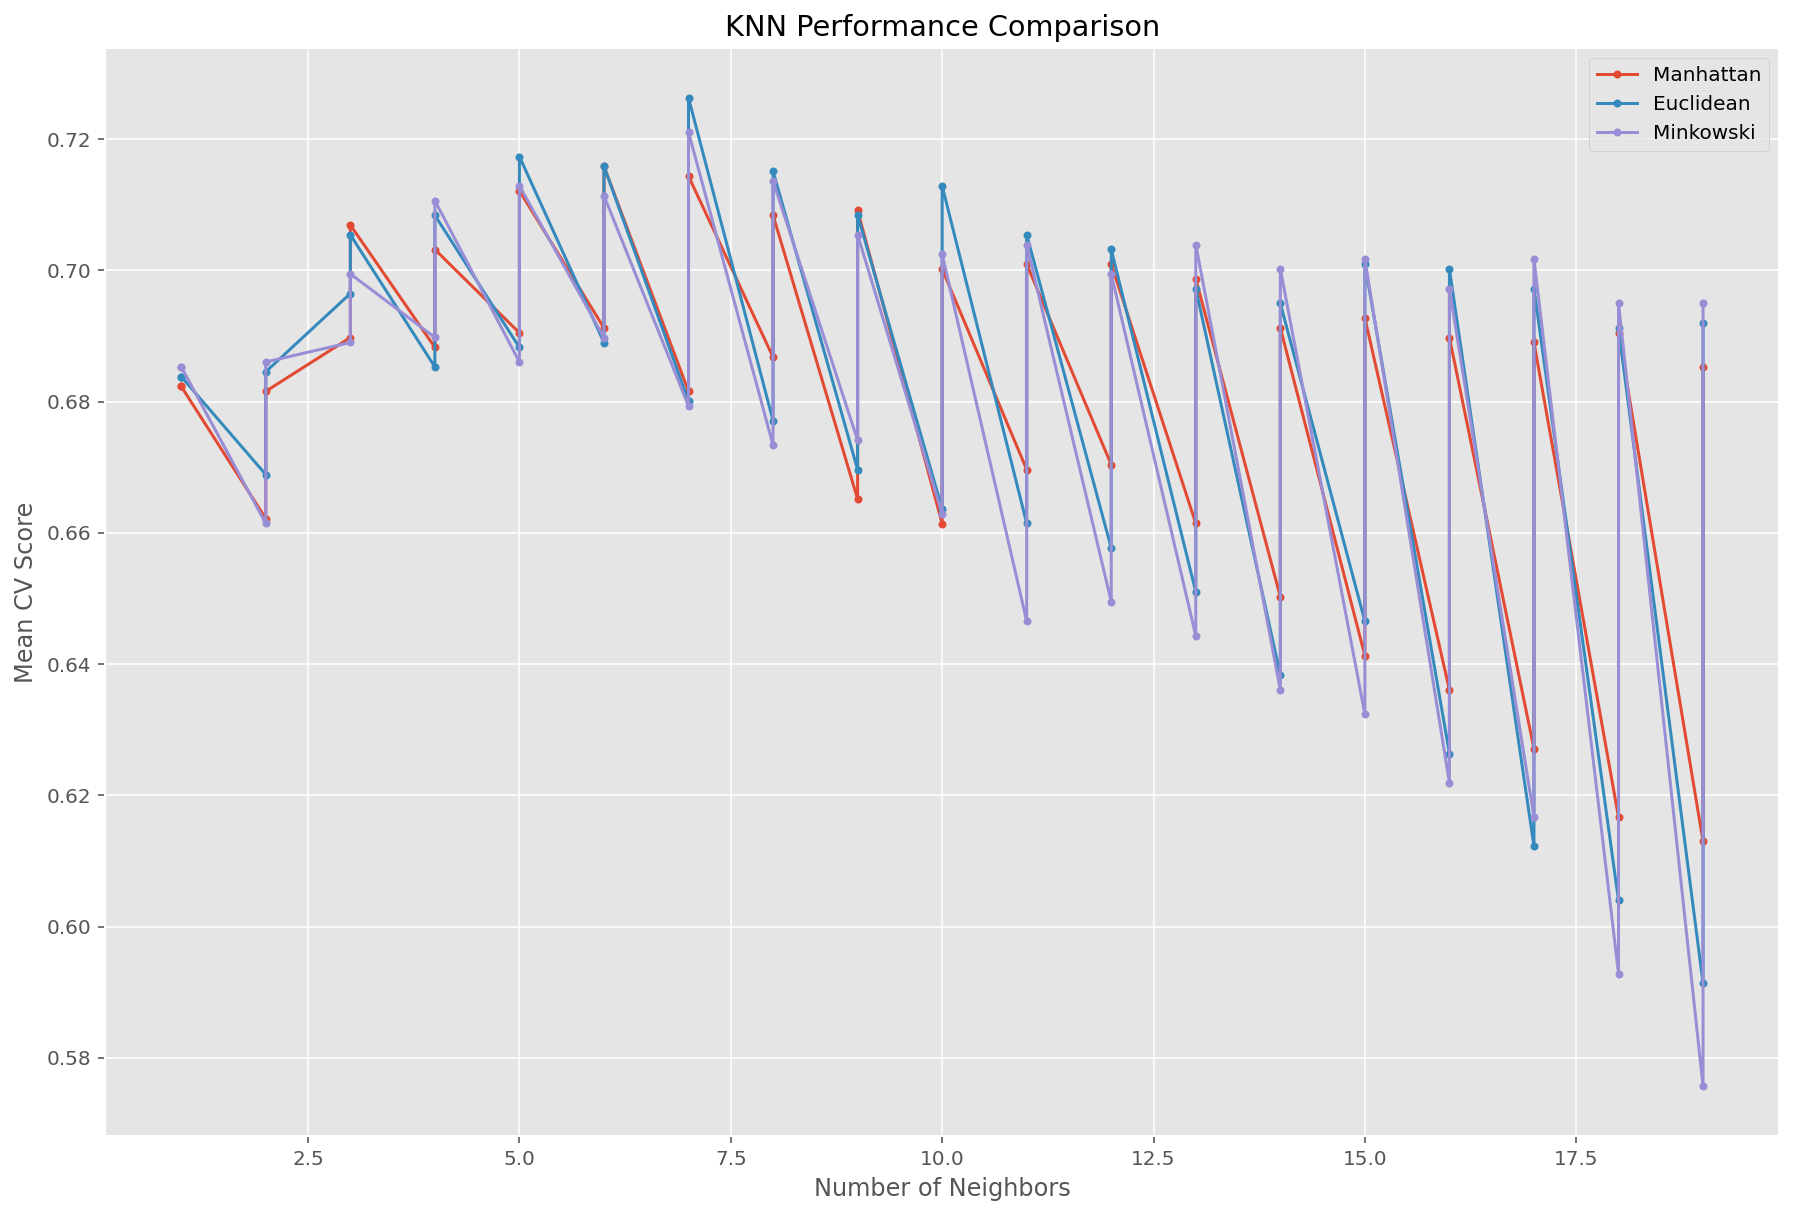

In [199]:

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = grid_results[grid_results['metric'] == i]
    _ = plt.plot(temp['knn__n_neighbors'], temp['test_score'], marker = '.', label = i)
    
_ = plt.legend()
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel("Mean CV Score")
_ = plt.title("KNN Performance Comparison")
plt.show()

## Run on test data

In [200]:
y_pred = overall_best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.62      0.68      0.65        90
    drummer5       0.71      0.68      0.70        84
    drummer7       0.59      0.60      0.59        82
    drummer8       0.89      0.82      0.86        80

    accuracy                           0.69       336
   macro avg       0.70      0.69      0.70       336
weighted avg       0.70      0.69      0.70       336



# kNN ensemble TODO, TRY THIS!!
* https://scikit-learn.org/stable/modules/ensemble.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [57]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Decision Tree

- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
- https://scikit-learn.org/stable/modules/tree.html

In [73]:
X_train.describe()
X_train_prepped = ct_v4.fit_transform(X_train)

tmp_df1 = pd.DataFrame(X_train_prepped)
tmp_df1.head()


,velocity,beat_offset,bar_beat_number
count,868.000000,868.000000,868.000000
mean,66.630184,1.645161,7.971198
std,31.754760,17.815041,4.580219
min,6.000000,-60.000000,1.000000
25%,43.000000,-8.250000,3.000000
50%,57.000000,1.000000,8.000000
75%,91.000000,13.000000,12.000000
max,127.000000,55.000000,16.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.555518,-1.889671,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.492499,0.188424,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.776085,0.132259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.232219,0.356918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.295238,0.076094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#tree_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=4)


tree_clf.fit(X_train_prepped, y_train)
#tree.plot_tree(tree_clf) 


DecisionTreeClassifier(max_depth=4)

In [75]:
from sklearn import metrics
X_test_prepped = ct_v4.fit_transform(X_test)
y_pred = tree_clf.predict(X_test_prepped)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5137614678899083


## GridSearchCV, DT

In [76]:
tree_clf = DecisionTreeClassifier(random_state=999)
dt_depth = list(np.arange(1, 20))

# can try modelling with scaling & dummies using previous setup ColTransformers...
#dt_prep_pipe = Pipeline(steps=[('prep',ct_v4), ('tree_clf', tree_clf)])

# apparently no scaling or dummies needed for DT
# new one to just encode 'note', leave everything else untouched
dt_enc_pipe = Pipeline(steps=[ ('enc', ct_note_enc), ('tree_clf', tree_clf)])

# setup param grid...
dt_params = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

# choose from dt_enc_pipe or dt_prep_pipe
my_clf = dt_enc_pipe

gscv_dt = GridSearchCV(estimator=my_clf, 
                     param_grid=dt_params, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

gscv_dt.fit(X_train, y_train);

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.6s finished


In [77]:
gscv_dt.best_params_

{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 7,
 'tree_clf__min_samples_split': 3}

In [78]:
gscv_dt.best_score_

0.5299786153434911

In [80]:
results_DT = pd.DataFrame(gscv_dt.cv_results_['params'])
results_DT['test_score'] = gscv_dt.cv_results_['mean_test_score']
results_DT.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

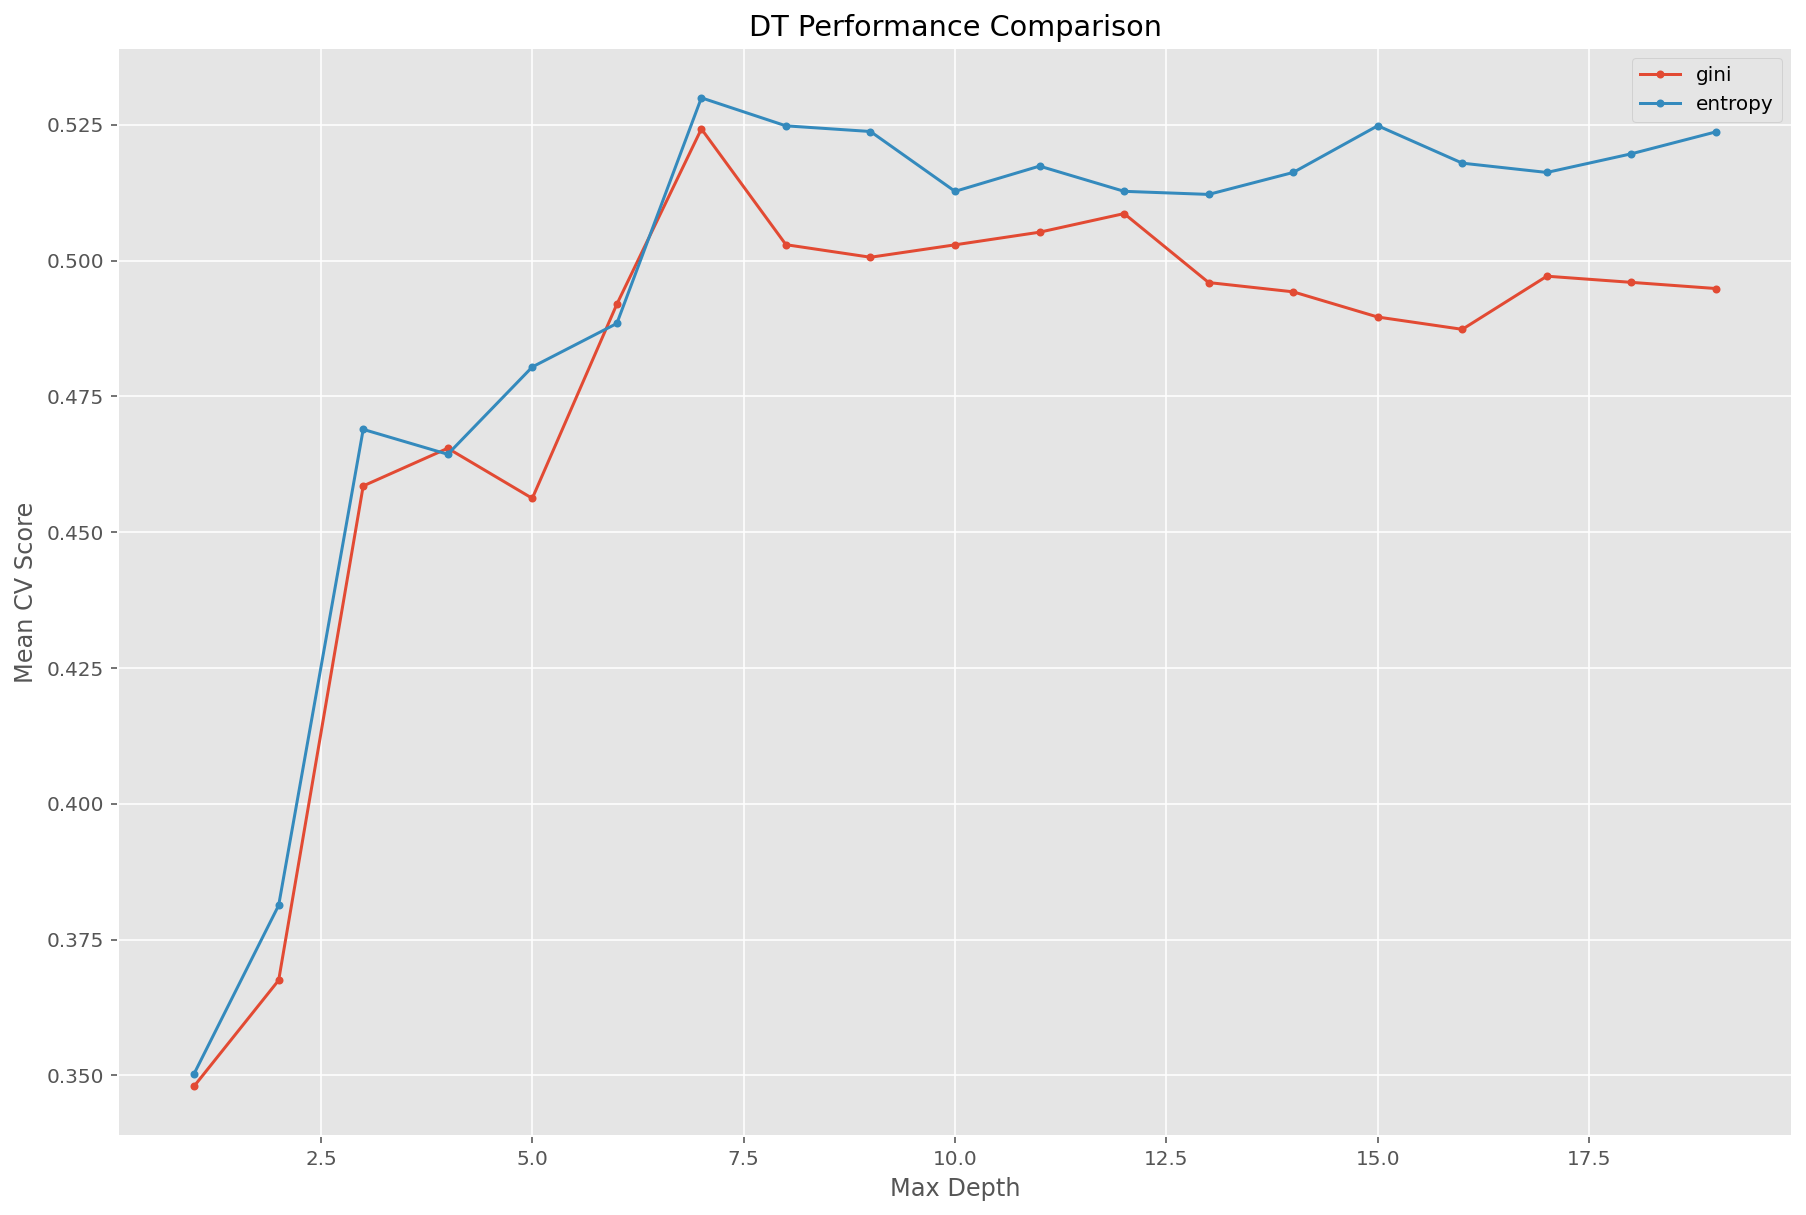

In [81]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['tree_clf__criterion'] == i]
    temp_average = temp.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## GridSearchCV, DT, manual loop

In [82]:
# list of ColumnTransformers setup previously
col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4, ct_note_enc]
#col_trans = [ct_v4, ct_note_enc]

dt_depth = list(np.arange(1, 20))

dt_params_grid = {'tree_clf__criterion': ['gini', 'entropy'],
             'tree_clf__max_depth': dt_depth,
             'tree_clf__min_samples_split': [2, 3]}

overall_best_score = 0
overall_best_classifier2 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  dt_pipe = Pipeline(steps=[('prep',ct), ('tree_clf', DecisionTreeClassifier(random_state=999))])
  gscv_dt = GridSearchCV(estimator=dt_pipe, 
                     param_grid=dt_params_grid, 
                     cv=10,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_dt.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_dt.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_dt.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_dt.best_params_)

  if gscv_dt.best_score_ > overall_best_score:
    overall_best_score = gscv_dt.best_score_
    overall_best_classifier2 = gscv_dt


_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



___BEST ESTIMATOR, pipe#0



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   12.0s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#0



0.5299919807538093


___BEST PARAMS, pipe#0



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #1.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#1



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   17.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])


___BEST SCORE, pipe#1



0.5404570970328789


___BEST PARAMS, pipe#1



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #2.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#2



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   15.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#2



0.5276931301790965


___BEST PARAMS, pipe#2



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #3.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#3



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   11.6s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=17,
                                        random_state=999))])


___BEST SCORE, pipe#3



0.5276931301790965


___BEST PARAMS, pipe#3



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 17,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #4.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#4



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:   13.4s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_std',
                                                  StandardScaler(), [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])


___BEST SCORE, pipe#4



0.5393076717455225


___BEST PARAMS, pipe#4



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



_______________________________________________________

>>>> PIPE #5.. 


>>>>FITTING ....

Fitting 10 folds for each of 76 candidates, totalling 760 fits

___BEST ESTIMATOR, pipe#5



[Parallel(n_jobs=1)]: Done 760 out of 760 | elapsed:    6.7s finished


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_label_enc',
                                                  OrdinalEncoder(), [0])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_split=3,
                                        random_state=999))])


___BEST SCORE, pipe#5



0.5299786153434911


___BEST PARAMS, pipe#5



{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 7,
 'tree_clf__min_samples_split': 3}

Overall ...

In [83]:
print('\n Overall .. BEST SCORE')
display(overall_best_classifier2.best_score_)

print('\n Overall .. BEST PARAMS')
display(overall_best_classifier2.best_params_)


 Overall .. BEST SCORE


0.5404570970328789


 Overall .. BEST PARAMS


{'tree_clf__criterion': 'entropy',
 'tree_clf__max_depth': 10,
 'tree_clf__min_samples_split': 2}

## Chart results

In [84]:
dt_results = pd.DataFrame(overall_best_classifier2.cv_results_['params'])
dt_results['test_score'] = overall_best_classifier2.cv_results_['mean_test_score']
dt_results.columns

Index(['tree_clf__criterion', 'tree_clf__max_depth',
       'tree_clf__min_samples_split', 'test_score'],
      dtype='object')

Text(0.5, 0, 'Max Depth')

Text(0, 0.5, 'Mean CV Score')

Text(0.5, 1.0, 'DT Performance Comparison')

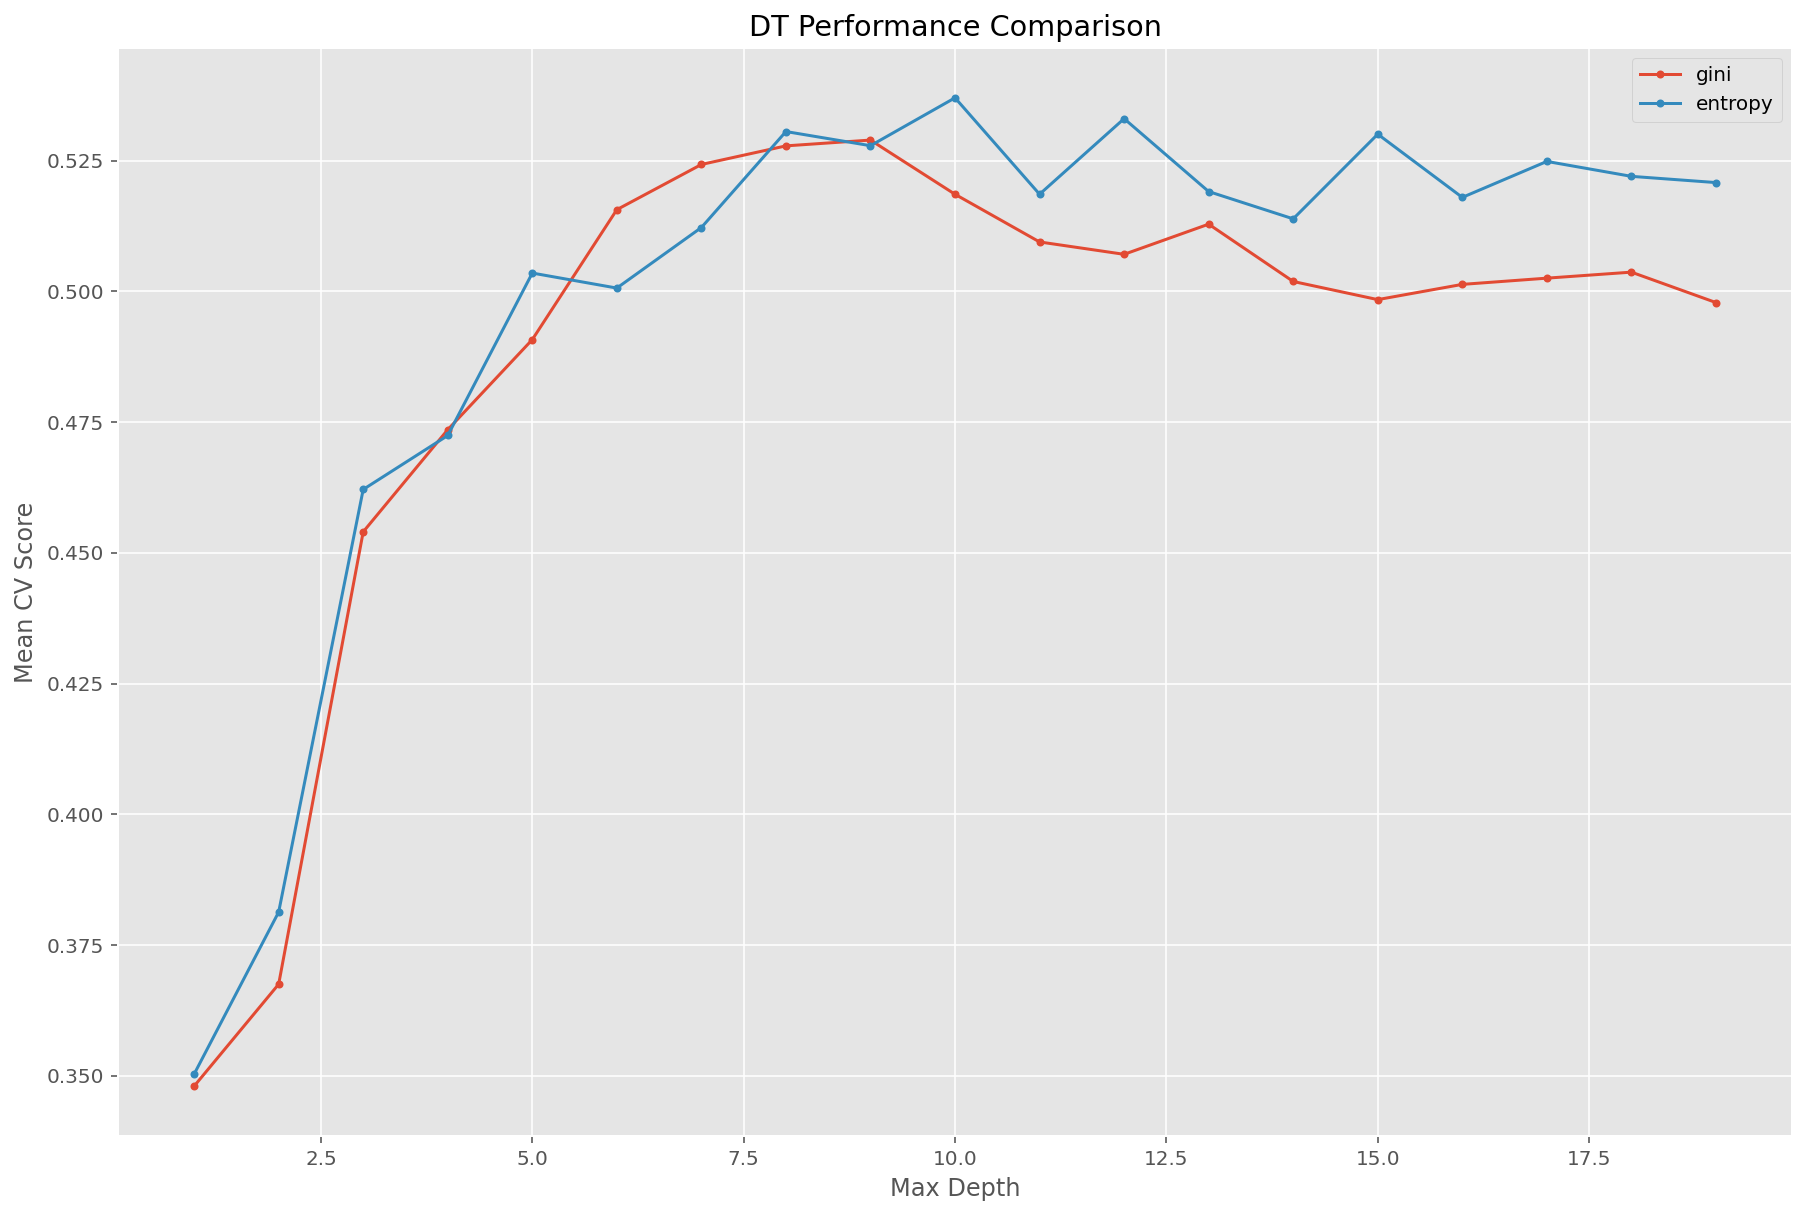

In [85]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,10)

for i in ['gini', 'entropy']:
    tmp_crit = dt_results[dt_results['tree_clf__criterion'] == i]
    tmp_avg = tmp_crit.groupby('tree_clf__max_depth').agg({'test_score': 'mean'})
    plt.plot(tmp_avg, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

## Run on test data

In [86]:
y_pred = overall_best_classifier2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    drummer1       0.50      0.48      0.49        52
    drummer5       0.53      0.48      0.50        60
    drummer7       0.65      0.48      0.55        50
    drummer8       0.47      0.64      0.55        56

    accuracy                           0.52       218
   macro avg       0.54      0.52      0.52       218
weighted avg       0.53      0.52      0.52       218



# SVM with RBF

* https://scikit-learn.org/stable/modules/svm.html#classification
* https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [87]:
from sklearn.svm import SVC

In [88]:
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.
#C_range = np.logspace(-2, 10, 13)
C_range = np.logspace(-2, 10, 3)
#gamma_range = np.logspace(-9, 3, 13)
gamma_range = np.logspace(-9, 3, 3)


In [89]:
print('C range: {}'.format(C_range))
print('Gamma range: {}'.format(gamma_range))

# list of ColumnTransformers setup previously
#col_trans = [ct_v0, ct_v1, ct_v2, ct_v3, ct_v4]
col_trans = [ct_v0]



svm_params_grid = {'svc_clf__gamma': gamma_range,
                  'svc_clf__C': C_range}

overall_best_score = 0
overall_best_classifier3 = None

for idx, ct in enumerate(col_trans):
  print("\n_______________________________________________________")
  print("\n>>>> PIPE #{}.. \n".format(idx))
  # iterate through all pipes in grid_cts
  svm_pipe = Pipeline(steps=[('prep',ct), ('svc_clf', SVC(kernel='rbf'))])
  gscv_svm = GridSearchCV(estimator=svm_pipe, 
                     param_grid=svm_params_grid, 
                     cv=5,
                     verbose=1, 
                     scoring='accuracy')

  print('\n>>>>FITTING ....\n')
  _ = gscv_svm.fit(X_train, y_train);

  print('\n___BEST ESTIMATOR, pipe#{}\n'.format(idx))
  display(gscv_svm.best_estimator_)

  print('\n___BEST SCORE, pipe#{}\n'.format(idx))
  display(gscv_svm.best_score_)

  print('\n___BEST PARAMS, pipe#{}\n'.format(idx))
  display(gscv_svm.best_params_)

  if gscv_svm.best_score_ > overall_best_score:
    overall_best_score = gscv_svm.best_score_
    overall_best_classifier3 = gscv_svm

C range: [1.e-02 1.e+04 1.e+10]
Gamma range: [1.e-09 1.e-03 1.e+03]

_______________________________________________________

>>>> PIPE #0.. 


>>>>FITTING ....

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  9.6min finished



___BEST ESTIMATOR, pipe#0



Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])


___BEST SCORE, pipe#0



0.4516576971629792


___BEST PARAMS, pipe#0



{'svc_clf__C': 10000000000.0, 'svc_clf__gamma': 0.001}

.... waiting on that last cell to complete!!!!!

# VotingClassifier

Review classifiers so far...

In [90]:
overall_best_classifier.best_estimator_
overall_best_classifier2.best_estimator_
overall_best_classifier3.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_mm_1',
                                                  MinMaxScaler(), [1]),
                                                 ('t_scaler_mm_2',
                                                  MinMaxScaler(feature_range=(-0.5,
                                                                              0.5)),
                                                  [2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0]),
                                                 ('t_one_hot_beat_pos',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12,
                                                                             13,
                                                                             14,
                                                                             15,
                                                                             16]],
                                                                drop='first'),
                                                  [3])])),
                ('tree_clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        random_state=999))])

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('t_scaler_robust',
                                                  RobustScaler(quantile_range=(25,
                                                                               75)),
                                                  [1, 2]),
                                                 ('t_one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  [0])])),
                ('svc_clf', SVC(C=10000000000.0, gamma=0.001))])

Create a voting ensemble aggregate of all prior best classifiers...

In [91]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(estimators=[('knn', overall_best_classifier.best_estimator_), 
                                    ('dt', overall_best_classifier2.best_estimator_), 
                                    ('svm', overall_best_classifier3.best_estimator_), 
                                    ],voting='hard')

In [92]:
for clf, label in zip([overall_best_classifier.best_estimator_, 
                       overall_best_classifier2.best_estimator_, 
                       overall_best_classifier3.best_estimator_, 
                       eclf],
                      ['KNN', 'DT', 'SVM', 'Ensemble']):
  scores = cross_val_score(clf, X, y, scoring='accuracy', cv=3)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.61 (+/- 0.02) [KNN]
Accuracy: 0.50 (+/- 0.03) [DT]
Accuracy: 0.47 (+/- 0.00) [SVM]
Accuracy: 0.59 (+/- 0.01) [Ensemble]
